In [1]:
import os
from pathlib import Path
import time
import copy

import numpy as np
import pandas as pd
from sklearn import metrics, model_selection

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from joblib import Parallel, delayed
from tqdm import tqdm

import cv2
import albumentations as A
import matplotlib.pyplot as plt
%matplotlib inline

from project.infrastructure.model_trainer import Model
from project.infrastructure.img_dataset import ImageDataset
import project.infrastructure.utils as utils
import project.infrastructure.pytorch_util as ptu

In [2]:
current_dir = Path.cwd()
home_dir = Path.home()
print(f"current_dir: {current_dir}")
print(f"home_dir:{home_dir}")

current_dir: /home/yiw084/Documents/GitHub/ECE_228-Team-4/project/test
home_dir:/home/yiw084


In [3]:
# Config data_dir, img_dir
data_dir = Path("../../data/")
leaf_data_dir: str = "cassava-leaf-disease-classification/"
csv_file_name: str = "train.csv"

csv_file_path = data_dir/leaf_data_dir/csv_file_name

In [4]:
img_folder_name: str = "train_images"
img_dir = data_dir/leaf_data_dir/img_folder_name

In [5]:
df = pd.read_csv(csv_file_path)
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [6]:
# Noticed that the dataset is unbalanced
df["label"].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [7]:
# Set seed
SEED = 42
np.random.seed(SEED)
torch.random.manual_seed(SEED)

In [8]:
# set overflow warning to error instead
np.seterr(all='raise')
torch.autograd.set_detect_anomaly(True)

# For convolutional networks only!
# Enable cuDNN Auto-tuner before launching training loop
torch.backends.cudnn.benchmark = True

In [9]:
# Split dataset into train and valid
df_train, df_valid = model_selection.train_test_split(
    df,
    test_size=0.1,
    train_size=0.9,
    random_state=SEED,
    stratify=df.label.values
)
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_train.shape, df_valid.shape

((19257, 2), (2140, 2))

In [10]:
df_train.head()

,image_id,label
0,1724663202.jpg,1
1,1443500189.jpg,0
2,3794321240.jpg,3
3,358823158.jpg,3
4,681211585.jpg,4


In [11]:
df_valid.head()

,image_id,label
0,3512385051.jpg,4
1,592844774.jpg,3
2,3547680343.jpg,4
3,41606397.jpg,1
4,2417340627.jpg,2


In [12]:
# Get image path for both training and validation
# Remember to convert path object to str!!
train_img_paths = [str(img_dir/img_id) for img_id in df_train["image_id"].values]
valid_img_paths = [str(img_dir/img_id) for img_id in df_valid["image_id"].values]

# Get image label for both training and validation
train_targets = df_train.label.values
valid_targets = df_valid.label.values

# Verify img paths
train_img_paths[:3], valid_img_paths[:3]

(['../../data/cassava-leaf-disease-classification/train_images/1724663202.jpg',
  '../../data/cassava-leaf-disease-classification/train_images/1443500189.jpg',
  '../../data/cassava-leaf-disease-classification/train_images/3794321240.jpg'],
 ['../../data/cassava-leaf-disease-classification/train_images/3512385051.jpg',
  '../../data/cassava-leaf-disease-classification/train_images/592844774.jpg',
  '../../data/cassava-leaf-disease-classification/train_images/3547680343.jpg'])

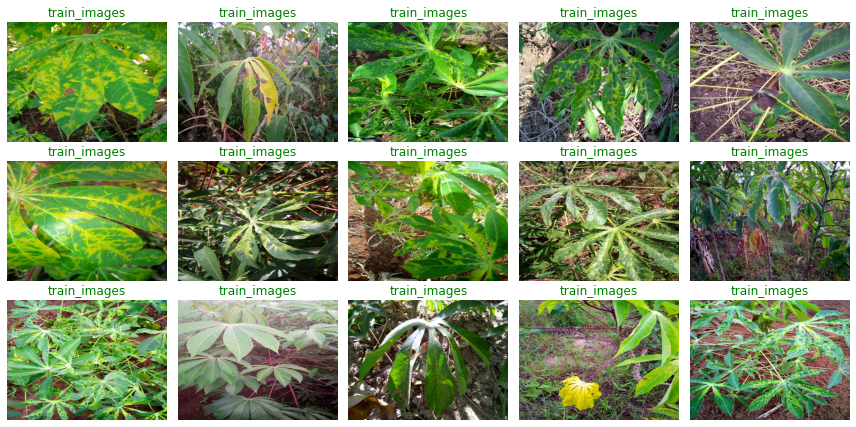

In [13]:
utils.display_image_grid(images_filepaths=train_img_paths[0:15])

In [14]:
train_img_aug = A.Compose(
    [
        A.RandomResizedCrop(width=256, height=256),
        A.Transpose(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(
            shift_limit=(0.2, 0.2), scale_limit=(1.1, 1.1), rotate_limit=(45, 45), p=0.5
        ),
        A.GridDistortion(p=0.5),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

valid_img_aug = A.Compose(
    [
        A.RandomCrop(width=256, height=256, p=1.0),
        A.Resize(width=256, height=256),
        A.Transpose(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

In [15]:
# Create training and validation dataset
train_dataset = ImageDataset(
    image_paths=train_img_paths,
    targets=train_targets,
    augmentations=train_img_aug
)

valid_dataset = ImageDataset(
    image_paths=valid_img_paths,
    targets=valid_targets,
    augmentations=valid_img_aug
)

print(train_dataset[100], '\n')
print(type(train_dataset[100]))

{'image': tensor([[[198., 202., 206.,  ..., 143., 140., 138.],
         [192., 197., 201.,  ..., 140., 139., 138.],
         [187., 192., 197.,  ..., 138., 139., 139.],
         ...,
         [115., 110., 105.,  ..., 148., 150., 152.],
         [112., 109., 106.,  ..., 147., 147., 148.],
         [113., 111., 107.,  ..., 145., 145., 145.]],

        [[221., 224., 226.,  ..., 158., 156., 153.],
         [218., 220., 224.,  ..., 157., 156., 154.],
         [215., 218., 222.,  ..., 156., 156., 155.],
         ...,
         [133., 132., 127.,  ..., 154., 153., 153.],
         [123., 127., 127.,  ..., 153., 152., 151.],
         [116., 122., 125.,  ..., 152., 150., 150.]],

        [[154., 157., 160.,  ..., 148., 146., 145.],
         [151., 155., 157.,  ..., 149., 148., 147.],
         [149., 152., 156.,  ..., 149., 150., 149.],
         ...,
         [105., 103.,  98.,  ..., 149., 151., 152.],
         [ 97.,  99.,  99.,  ..., 149., 149., 150.],
         [ 94.,  97.,  98.,  ..., 148., 148

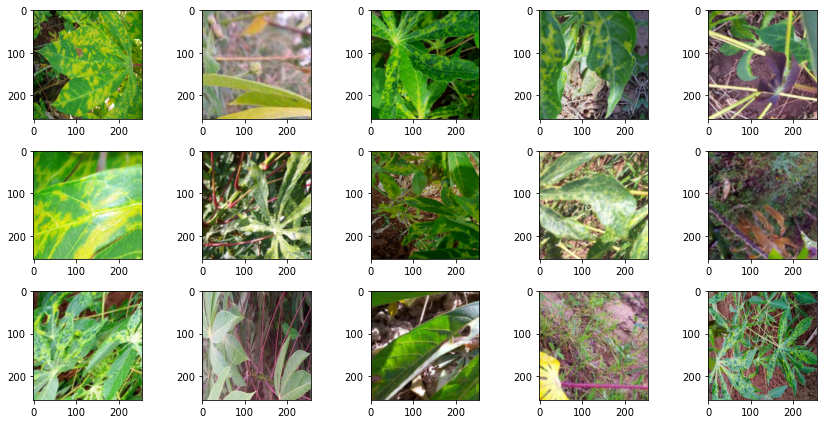

In [16]:
# Visualize training images after augmentation
train_images_array_lst = [train_dataset[i]['image'] for i in range(15)]
utils.display_image_grid(images_array_lst=train_images_array_lst)

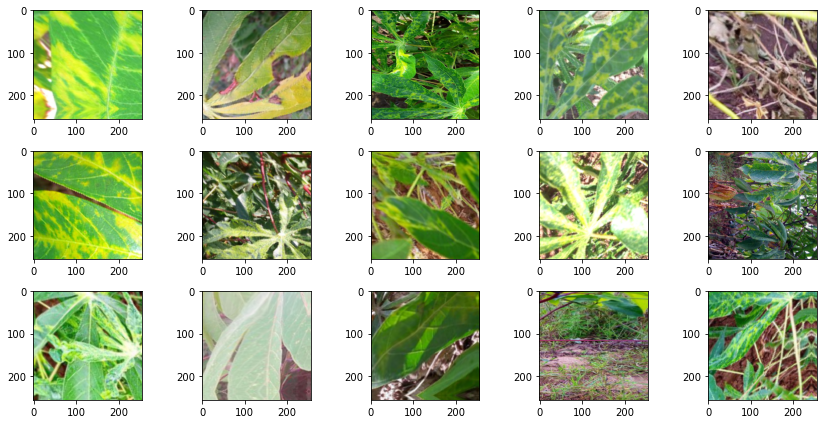

In [17]:
# Visualize validation images after augmentation
valid_images_array_lst = [train_dataset[j]['image'] for j in range(15)]
utils.display_image_grid(images_array_lst=valid_images_array_lst)


In [18]:
class LeafDiseaseClassifier(Model):
    def __init__(self, num_classes, pretrained):
        super().__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=pretrained)
        self.resnet18.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)

    def config_optimizer(self, *args, **kwargs):
        opt = torch.optim.Adam(self.parameters(), lr=5e-4)
        return opt

    # def config_scheduler(self, *args, **kwargs):
    #     assert self.optimizer is not None, "Please set up optimizer first"
    #     sch = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=30, verbose=False)
    #     return sch

    @staticmethod
    def loss_fn(outputs, targets, criterion=None):
        """ calculate loss """
        if targets is None or criterion is None:
            print("Targets is None or Criterion is None")
            return None
        return criterion(outputs, targets)

    def forward(self, x, targets):
        out: torch.FloatTensor = self.resnet18(x)
        criterion = nn.CrossEntropyLoss()
        loss: torch.FloatTensor = self.loss_fn(out, targets, criterion)
        return out, loss

    def monitor_metrics(self, outputs, targets) -> dict:
        if targets is None:
            return {}
        outputs: np.ndarray = ptu.to_numpy(torch.argmax(outputs, dim=1))
        targets: np.ndarray = ptu.to_numpy(targets)
        accuracy = metrics.accuracy_score(targets, outputs)
        val_metrics = {
            "acc": accuracy,
        }
        return val_metrics

In [19]:
# Create ResNet50
resnet18_model = LeafDiseaseClassifier(num_classes=df.label.unique().shape[0], pretrained=True)

In [20]:
# Check if NN build successfully
img = train_dataset[0]["image"]
target = train_dataset[0]["target"]
img, target

(tensor([[[194., 184., 177.,  ..., 145., 146., 146.],
          [188., 176., 168.,  ..., 149., 149., 149.],
          [184., 165., 156.,  ..., 150., 150., 150.],
          ...,
          [ 82.,  80.,  80.,  ...,  59.,  62.,  62.],
          [ 83.,  84.,  83.,  ...,  60.,  60.,  60.],
          [ 83.,  84.,  83.,  ...,  60.,  60.,  60.]],
 
         [[203., 196., 192.,  ..., 190., 190., 190.],
          [197., 187., 191.,  ..., 187., 185., 185.],
          [199., 191., 192.,  ..., 182., 180., 180.],
          ...,
          [171., 170., 170.,  ..., 164., 163., 163.],
          [172., 171., 171.,  ..., 162., 162., 162.],
          [172., 171., 171.,  ..., 162., 162., 162.]],
 
         [[ 49.,  42.,  39.,  ...,  54.,  56.,  56.],
          [ 40.,  32.,  34.,  ...,  54.,  55.,  55.],
          [ 39.,  29.,  29.,  ...,  52.,  53.,  53.],
          ...,
          [ 32.,  29.,  27.,  ...,  42.,  31.,  31.],
          [ 33.,  30.,  27.,  ...,  44.,  34.,  34.],
          [ 33.,  30.,  27.,  .

In [21]:
# Build success
resnet18_model(img.unsqueeze(0), target.unsqueeze(0))

(tensor([[ 0.0282,  0.5519, -0.2750,  0.7760,  0.2968]],
        grad_fn=<AddmmBackward>),
 tensor(1.4001, grad_fn=<NllLossBackward>))

In [22]:
# Init GPU if available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)

cuda:0


In [23]:
# training param
params = {
    "max_epochs": 10,
    "train_batch_size": 32,
    "valid_batch_size": 32*2,
    'fp16': True,
    'seed': 42,
    'no_gpu': False,
    'which_gpu': 0,
    'num_workers': -1,
    'learning_rate': 5e-4,
    
}


In [ ]:
resnet18_model.init_trainer(params)
history = resnet18_model.fit(
    train_dataset=train_dataset, train_batch_size=params["train_batch_size"],
    valid_dataset=valid_dataset, valid_batch_size=params["valid_batch_size"],
    max_epochs=params["max_epochs"], device=device,
    num_workers=params["num_workers"], use_fp16=params['fp16'],
                    
)

Using GPU id 0
############ cuda:0 ############


LDC:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
train_losses = history['train_loss']
val_losses = history['val_loss']
plt.plot(train_losses, '-x')
plt.plot(val_losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()

